# Introduction
In this project, I will do a sentiment analysis with Random Forest Classifier for a supervised dataset containing some tweets and detailed information about regarding tweets. Data can be found [here](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

### Table of contents
- [Reading and cleaning the data](#Reading-and-cleaning-the-data)
- [Feature engineering](#Feature-engineering)
- [Preprocessing](#Preprocessing)
- [Model evaluation](#Model-evaluation)
- [Conclusion](#Conclusion)

## Reading and cleaning the data
I'll start with importing necessary libraries and modules and then read the csv file into pandas dataframe. Then, I will clean the dataset to make it ready for the preprocessing step.

In [1]:
# Import libraries and modules
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Read the data into a pandas dataframe
data = pd.read_csv("data/Tweets.csv", sep=",")
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Even though there are many information in this dataset, I'll be using only two columns which are 'airline_sentiment' and 'text'. So, let's start with creating a new dataframe for that information only.

In [3]:
# Create a new dataframe for only two columns
tweets = data.loc[:,['airline_sentiment','text']]
tweets.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


Since the rows in 'text' column contains many words and punctuations that I will not need for analysis, I'll clean those first. In this step, I'll remove all punctuations, mentions in tweets (the words starting with @), convert everything to lower case, tokenize and lemmatize the words and remove the stopwords.

In [4]:
import re
import string

# Stopwords in English language
stopword = nltk.corpus.stopwords.words('english')

# Lemmatizer
wn = nltk.WordNetLemmatizer()

# Function to clean and tokenize the data
def clean_tokenize_text(text):
    # Remove mentions starting with @
    text = re.sub('@\w+\s', '', text)
    
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    text = text.lower()
    
    # Tokenize the text
    tokens = re.split('\W+', text)
    
    # Remove stopwords
    text = [word for word in tokens if word not in stopword]
    
    # Lemmatize the words
    text = [wn.lemmatize(word) for word in text]
    
    # Return text
    return text


# Apply the function to text column
tweets['text'] = tweets['text'].apply(lambda x: clean_tokenize_text(x))

# Display first five rows
tweets.head()

,airline_sentiment,text
0,neutral,[said]
1,positive,"[plus, youve, added, commercial, experience, t..."
2,neutral,"[didnt, today, must, mean, need, take, another..."
3,negative,"[really, aggressive, blast, obnoxious, enterta..."
4,negative,"[really, big, bad, thing]"



## Feature engineering

In this step, I want to see if creating a new feature may have any impact on model's performance in next steps. As a new feature, text length may be added to see if negative, neutral or positive tweets have much difference in text length. For this purpose, I will use the word count in tweets in the uncleaned dataset. It includes mentions as well, but since it's a dataset consists of tweets which were written to airlines, almost all of them should include mentions in them. Even if they don't, it's not important in this step.

In [5]:
# Create a new column for word count in a tweet
tweets['text_len'] = data['text'].apply(lambda x: len(x) - x.count(' '))

# Rename the columns
tweets.columns=['label','body','text_len']

tweets.head()

,label,body,text_len
0,neutral,[said],32
1,positive,"[plus, youve, added, commercial, experience, t...",64
2,neutral,"[didnt, today, must, mean, need, take, another...",60
3,negative,"[really, aggressive, blast, obnoxious, enterta...",110
4,negative,"[really, big, bad, thing]",46


Let's see the density distribution of word counts in every tweet in our dataset.

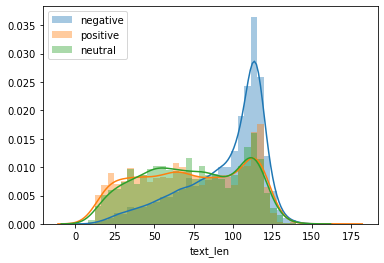

In [6]:
# Import libraries
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

# Create a density plot for word counts for each label
bins = np.linspace(0,140,35)
sns.distplot(tweets[tweets['label']=='negative']['text_len'], bins, label='negative')
sns.distplot(tweets[tweets['label']=='positive']['text_len'], bins, label='positive')
sns.distplot(tweets[tweets['label']=='neutral']['text_len'], bins, label='neutral')
plt.legend(loc='upper left')
plt.show()

It seems like while the distribution word counts in neutral and positive tweets almost the same, negative tweets have more words then the others. It might be because people tend to write more words when they are angry or upset or complaining about something to explain the situation.

## Preprocessing
Now, I'll split train and test set and vectorize them with TF-IDF Vectorizer. But first, I'll create the dataset again to be used in the model because this time I will not clean and tokenize the dataset before splitting text and train sets since TF-IDF Vectorizer does it already with the function passed in.

### Train/Test set split

In [7]:
# Create a new dataframe for 'airline_sentiment' and 'text' columns
data = data.loc[:,['airline_sentiment','text']]

# Rename the columns
data.columns = ['label', 'body']

# Create a column for word counts in each tweet except for white spaces
data['text_len'] = data['body'].apply(lambda x: len(x) - x.count(" "))

# Import module
from sklearn.model_selection import train_test_split

# Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(data[['body', 'text_len']], data['label'], test_size=0.2)

### Vectorizing the text
After creating a TF-IDF Vectorizer, I will only fit the train set because I don't want it to know the words in test set. Giving all the data to the model to fit may impact test set accuracy in later steps.

In [8]:
# Create a TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(analyzer=clean_tokenize_text)

# Fit the train set
tfidf_vect_fit = tfidf_vect.fit(X_train['body'])

# Transform train and test sets
tfidf_train = tfidf_vect_fit.transform(X_train['body'])
tfidf_test = tfidf_vect_fit.transform(X_test['body'])

# Create new dataframe for train and test sets including 'text_len' column
X_train_vect = pd.concat([X_train['text_len'].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)

X_test_vect = pd.concat([X_test['text_len'].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

# Display first 5 rows of vectorized train set
X_train_vect.head()


,text_len,0,1,2,3,4,5,6,7,8,...,13016,13017,13018,13019,13020,13021,13022,13023,13024,13025
0,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, we have a tf-idf vectorized dataframe for every word in the dataset. Also, I've added text_len feature to it. Let's see some of the feature names that appear in our vectorized dataset in the following code cell.

In [9]:
# Get the first 10 feature names in whole dataset
print(tfidf_vect.get_feature_names()[0:10])

['', '0', '00', '0011', '0016', '0162389030167', '0162424965446', '0162431184663', '0167560070877', '0214']


## Model evaluation

Let's try Grid Search for Random Forest Classifier to find the most ideal hyperparameters for the model.

### Grid Search with Random Forest Classifier

In [10]:
# Import random forest classifier
from sklearn.ensemble import RandomForestClassifier

# Import cross validation score evaluation
from sklearn.model_selection import cross_val_score

# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

In [11]:
# Define parameters
param = {
    'n_estimators': [10, 50, 100], 
    'max_depth': [10, 20, 30, None],
    }

# Create a model
clf = GridSearchCV(RandomForestClassifier(), param,cv=5, n_jobs=-1)

# Fit the vectorized train set
rf_model = clf.fit(X_train_vect, y_train)

# Create a dataframe for the cross validation results
pd.DataFrame(rf_model.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,77.454372,3.876513,1.172109,0.055045,None,50,"{'max_depth': None, 'n_estimators': 50}",0.744772,0.740930,0.746371,0.744236,0.748506,0.744963,0.002504,1
11,128.153650,21.453451,1.357676,0.432959,None,100,"{'max_depth': None, 'n_estimators': 100}",0.741357,0.745198,0.750213,0.744663,0.743382,0.744963,0.002940,2
9,25.978453,3.437641,1.092354,0.122980,None,10,"{'max_depth': None, 'n_estimators': 10}",0.740077,0.732821,0.730145,0.734415,0.731853,0.733862,0.003402,3
6,17.374115,2.694442,0.900011,0.152493,30,10,"{'max_depth': 30, 'n_estimators': 10}",0.655997,0.666240,0.658412,0.665243,0.654569,0.660092,0.004784,4
8,44.235737,2.440453,0.921467,0.073306,30,100,"{'max_depth': 30, 'n_estimators': 100}",0.654289,0.653436,0.648591,0.654996,0.653288,0.652920,0.002251,5


So, it seems like random forest classifier with n_estimators=100 or n_estimators=50 and max_depth=None parameters would give us the best result with 0.75 mean test score for this dataset. Let's finalize our model with the given hyperparameters.

### Finalizing the model
I will set the hyperparameters to the ones that grid search gave the best result with and calculate some evaluation metrics to see the model's performance.

In [12]:
# Create a model with defined parameters
rf_class = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1)

# Fit the vectorized train set to the model
rf_model = rf_class.fit(X_train_vect, y_train)

In [13]:
# Display feature importances with feature names
sorted(zip(rf_model.feature_importances_, X_train_vect.columns), reverse=True)[0:10]

[(0.05040632964104125, 'text_len'),
 (0.0273847344517721, 11528),
 (0.025872319646611176, 11521),
 (0.010237841163773699, 5920),
 (0.009549482468141144, 5508),
 (0.009340635227111498, 0),
 (0.008843366357144328, 4956),
 (0.006492490435110875, 7908),
 (0.005472417419324286, 3678),
 (0.005204042406377197, 5825)]

We can see that the feature 'text_len' that gives the word count for each tweet has the best impact on our model.

In [14]:
from sklearn.metrics import precision_recall_fscore_support as score

# Predict the vectorized test set
y_pred = rf_model.predict(X_test_vect)

# Get scores
precision, recall, fscore, support = score(y_test, y_pred, average='weighted')

In [15]:
# Save the model
import joblib
joblib.dump(rf_model, 'rf_model.pkl')

['rf_model.pkl']

In [16]:
# Print the scores
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3),
                                                        round(recall, 3),
                                                        round((y_pred==y_test).sum() / len(y_pred),3)))

Precision: 0.753 / Recall: 0.759 / Accuracy: 0.759


In [17]:
from sklearn.metrics import classification_report

# Create a classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.77      0.95      0.85      1795
     neutral       0.69      0.39      0.50       644
    positive       0.79      0.54      0.64       489

    accuracy                           0.76      2928
   macro avg       0.75      0.63      0.66      2928
weighted avg       0.75      0.76      0.74      2928



## Conclusion

In conclusion, the model is the best in predicting 'negative' tweets correctly with 0.77 precision, 0.95 recall and 0.85 f-1 scores. And it's not as good in predicting the other classes. But overall, it has 76.0% accuracy rate in predicting which class a tweet belongs to. 